## Authors: Aishwarya Mathew, Vikram Yabannavar

# SPAMIFIER - A Spam Text Classifier

## Introduction

Data science is all around us. It is an interdisciplinary field of study that strives to discover meaning behind data. Finding a good first data science project to work on is a hard task. You may know a lot of data science concepts but you get stuck when you want to apply your skills to real world tasks. However, you've come to the right place! Have you ever wanted to make an application that could distinguish between some bad thing and a good thing? This tutorial will do just that. It's actually a basic introduction to the world of data science. This project will teach you how to perform text classification by creating a spam classifier/filter that will distinguish between spam and not spam (we call this ham) SMS messages and emails. We will take you through the entire data science lifecycle which includes data collection, data processing, exploratory data analysis and visualization, machine learning and insight/policy decision.

### Tutorial Content

In this tutorial, you will learn how to build a text classifier using Scikit-Learn. Scikit-Learn is a popular open source Python library used for machine learning purposes.

The SMS spam and ham data for our tutorial will come from a website called Kaggle which is a huge repository for different kinds of data. The email spam and ham data will be collected from Andrew Ng's Machine Learning course at Stanford.

This tutorial will go over the following topics:

* [Importing Libraries](#libraries)
<br>
* [Loading Data](#load data)
<br>
 - [SMS Data](#sms1)
<br>
 - [Email Data](#email1)
<br>
* [Processing Data](#process data)
<br>
 - [SMS Data](#sms2)
<br>
 - [Email Data](#email2)
<br>
* [Exploratory Analysis and Data Visualization](#eda)
<br>
 - [SMS Messages](#spam1)
<br>
 - [Finding Words Used Only in Spam SMS Messages](#1)
<br>
 - [Email Messages](#spam2)
<br>
 - [Finding Words Used Only in Spam Emails](#2)
<br>
 - [Finding the Most Common Words Across Spam Email and Spam SMS](#3)
<br>
* [Building a Basic Text Classifier Using Machine Learning](#4)
<br>
 - [Transform SMS Data](#5)
<br>
 - [Transform Email Data](#6)
<br>
 - [Calculating Classifier Metrics](#7)
<br>
 - [Evaluating Classifiers](#8)
<br>
 - [Example Application of Chosen Best Classifer on SMS and Email Messages](#9)

<a id='libraries'></a>
## Importing Libraries

Before getting started, you will need to import these libraries which we will use throughout the tutorial.

In [349]:
# Import data manipulation and plotting libraries
import pandas as pd
import csv
import re
import string
import matplotlib.pyplot as plt
import numpy as np
# Import Scikit-Learn library functions
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn import linear_model
# Import Scikit-Learn classifiers
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier

<a id='load data'></a>
## Loading Data 

The first step of any data science project is data collection. Kaggle is a dataset website that has a lot of real world data. To get started, you need to click on this link, https://www.kaggle.com/uciml/sms-spam-collection-dataset , to download the SMS spam vs. ham dataset from Kaggle to your local disk. You will have to create a user account on Kaggle to download any of their datasets. Once you have downloaded the 'spam.csv' file, you need to place that file in the same folder as this notebook. Please also change the 'spam.csv' file's name to 'sms.csv' for later use. For email data, we will use the dataset provided by Andrew Ng's Machine Learning course at Stanford. That data can be found [here](http://openclassroom.stanford.edu/MainFolder/courses/MachineLearning/exercises/ex6materials/ex6DataEmails.zip). After you've downloaded the zipped file, unzip the file and place the four resulting folders in the same folder as this notebook. Once placed, you can run 'txt_to_csv.py' to generate a CSV file of all the files in those folders, or you can download 'email.csv' from the GitHub repository. 

Next, we will load both datasets into two different pandas dataframes.

<a id='sms1'></a>
### SMS Data

In [350]:
# Read the SMS data into a pandas dataframe
SMS_spamham_data = pd.read_csv("sms.csv", encoding='latin-1')
SMS_spamham_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<a id='email1'></a>
### Email Data

In [351]:
# Read the email data into a pandas dataframe
email_spamham_data = pd.read_csv("email.csv", encoding='latin-1')
email_spamham_data.head()

,class,message
0,spam,great parttime summer job display box credit a...
1,spam,auto insurance rate too high dear nlpeople m s...
2,spam,want best economical hunt vacation life want b...
3,spam,email million million email addresses want mon...
4,spam,amaze world record sex attention warn adult wa...


<a id='process data'></a>
## Processing Data

As you can see above, our data is not tidy. The SMS dataframe has unknown values and unnecessary columns. So our next step is to prepare the data. In the code below, we will process the data to make it clean and easy to use.

<a id='sms2'></a>
### SMS Data

In [352]:
# Remove unnecessary columns and values
del SMS_spamham_data['Unnamed: 2']
del SMS_spamham_data['Unnamed: 3']
del SMS_spamham_data['Unnamed: 4']
# Rename the remaining two columns
SMS_spamham_data.columns = ['Spam or Ham','SMS Message']

# The resulting clean dataframe with SMS data
SMS_spamham_data.head()

,Spam or Ham,SMS Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<a id='email2'></a>
### Email Data

In [353]:
# Renaming the two columns for consistency
email_spamham_data.columns = ['Spam or Ham','Email Message']
email_spamham_data.head()

,Spam or Ham,Email Message
0,spam,great parttime summer job display box credit a...
1,spam,auto insurance rate too high dear nlpeople m s...
2,spam,want best economical hunt vacation life want b...
3,spam,email million million email addresses want mon...
4,spam,amaze world record sex attention warn adult wa...


<a id='eda'></a>
## Exploratory Analysis and Data Visualization

In this section we are going to analyze our processed data. We will look at the words that are most frequently used in SMS and email spam messages. We will do the same for ham messages. This will help us understand what distinguishes spam messages from ham messages. While we are doing this, we will also plot a few graphs that will help us visualize this data.

<a id='spam1'></a>
### SMS Messages

We start by analyzing SMS data.

#### Finding The Top 50 Frequently Used Words in Spam SMS Messages

##### Get frequency of words
First, we are going to get the frequency of all the different words used in spam SMS messages.

In [354]:
# Dictionaries of word -> num occurrences
spam_words = {} 
ham_words = {}

# Strip punctuation
translator= str.maketrans('','',string.punctuation)

# First, we tokenize the words.
# To do this, we strip punctuation and split lines by spaces.
# Note that we do not convert to lowercase, so Free, free, and FREE 
# are all going to be different for our purposes.
# If a word isn't in its respective dictionary (spam_words or ham_words),
# we add it with default value 1, otherwise we increment 
# the word's number of occurrences by 1. 

for item,row in SMS_spamham_data.iterrows():
    # Remove punctuation
    line = row['SMS Message'].translate(translator)
    # Split by space
    line = line.split()
    
    for word in line:
        # If a spam message, add it or increment count
        # in spam_words
        if row['Spam or Ham'] == 'spam':
            if word in spam_words:
                spam_words[word] = spam_words[word] + 1
            else:
                spam_words[word] = 1
        # If ham, add or increment in ham_words
        else: 
            if word in ham_words:
                ham_words[word] = ham_words[word] + 1
            else:
                ham_words[word] = 1

# Create a dataframe for spam SMS messages
SMS_spam_df = pd.DataFrame.from_dict(spam_words,orient='index')
# Rename columns
SMS_spam_df.columns = ['count']
# Display dataframe
SMS_spam_df.head()

,count
FANTASIES,5
StdTxtRate,1
CHATLINES,1
want,16
alone,3


##### Top 50 frequently used words in spam SMS messages

In [355]:
SMS_spam_df['count'].nlargest(50)

to         608
a          358
call       189
your       187
you        185
or         185
the        178
2          173
for        170
is         149
on         138
Call       137
now        131
have       128
and        119
4          119
from       116
FREE       112
ur         107
with       102
mobile      95
of          93
U           85
claim       78
You         77
are         77
our         76
prize       73
To          73
text        72
Your        71
Txt         70
txt         70
in          68
free        62
STOP        62
u           62
only        58
reply       58
contact     56
be          50
16          49
won         49
service     49
week        48
who         48
out         47
send        47
just        47
Nokia       46
Name: count, dtype: int64

#### Finding The Top 50 Frequently Used Words in Ham SMS Messages

##### Get frequency of words
We will now get the frequency of all the different words used in ham SMS messages.

In [356]:
# Create dataframe for non-spam SMS messages
SMS_ham_df = pd.DataFrame.from_dict(ham_words,orient='index')
# Rename columns
SMS_ham_df.columns = ['count']
# Display dataframe
SMS_ham_df.head()

,count
Oi,2
pongaldo,2
nz,1
brownies,1
crave,11


##### Top 50 frequently used words in ham SMS messages

In [357]:
SMS_ham_df['count'].nlargest(50)

you     1624
to      1540
I       1448
the     1021
a        971
in       759
and      740
i        737
u        716
me       701
is       656
my       620
it       518
of       504
for      480
that     440
your     374
on       364
have     349
not      344
at       338
are      322
be       318
2        305
Im       301
can      293
will     293
get      290
so       284
but      278
ltgt     276
do       268
up       260
U        256
now      256
with     250
go       231
know     226
when     226
if       218
like     217
we       209
come     206
out      205
call     203
got      202
dont     202
all      199
this     192
just     192
Name: count, dtype: int64

Now that we've found the most commonly used words in spam and ham SMS messages, notice that many of the words are similar since words such as 'u','and', and 'the' are common between both. Therefore, we will next find the words most commonly used only in spam SMS messages.

<a id='1'></a>
### Finding Words Used Only in Spam SMS Messages

##### Get frequency of words

In [358]:
# Get sets of all words in each dataframe
ham_set = set([ line for line in SMS_ham_df.index])
spam_set = set([ line for line in SMS_spam_df.index])

# Do set difference to get the words found in spam and not in ham
only_SMS_spam_set = spam_set.difference(ham_set)

# Filter the dataframe
# Note: This only contains the words used by spammers
only_SMS_spam_df = SMS_spam_df.ix[only_SMS_spam_set]
only_SMS_spam_df.head()

,count
FANTASIES,5
CHATLINES,1
TMobile,3
85555,1
SK38XH,1


##### 50 most commonly used words only in spam SMS messages

In [359]:
# Get top 50 SMS words
sms_largest = only_SMS_spam_df['count'].nlargest(50)
# Get top 15 SMS words (used for graphing)
sms_fifteen_largest = only_SMS_spam_df['count'].nlargest(15)
# Display top 50
sms_largest

claim         78
prize         73
won           49
18            43
URGENT        41
awarded       37
å£1000        35
150ppm        32
Claim         32
å£2000        31
TCs           29
PO            28
å£150         27
guaranteed    26
tone          26
collection    26
entry         25
500           25
WON           23
GUARANTEED    23
Orange        23
weekly        22
150p          22
å£100         22
Holiday       21
SAE           21
8007          21
TC            20
å£5000        20
Valid         20
Box           20
WIN           19
Prize         19
Todays        19
86688         19
å£500         19
land          18
ringtone      18
750           18
mob           18
tones         17
TsCs          17
vouchers      17
Urgent        17
Expires       17
Code          17
12hrs         17
Statement     16
å£250         16
Identifier    16
Name: count, dtype: int64

##### Visualize The Data

Since the words we need to graph must be displayed on the X-axis, we limit our graph to the top 15 words used by spammers. You can see that they correspond to the top 15 words in the sms_largest dataframe.

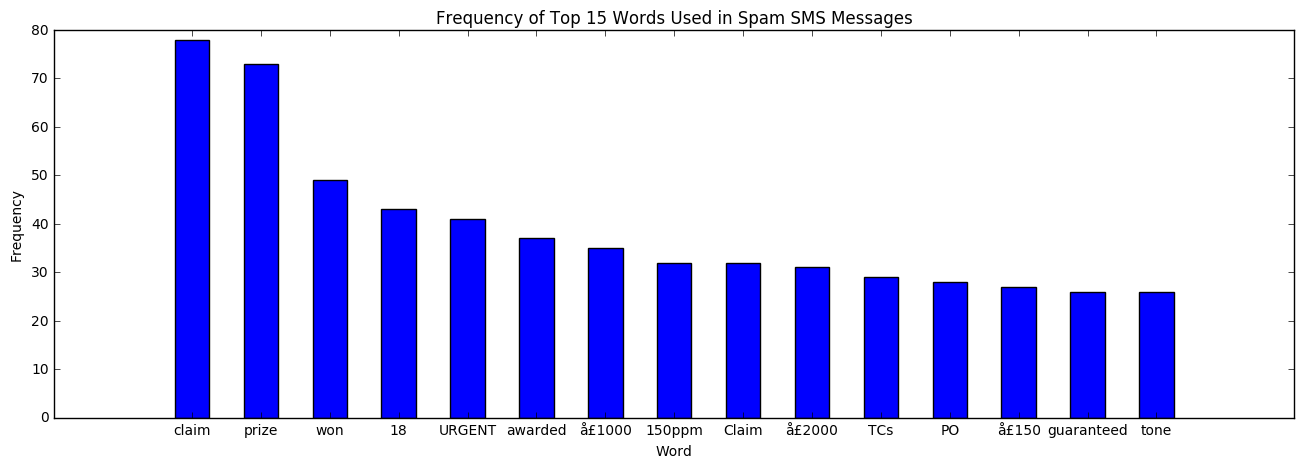

In [360]:
graph_x = list(sms_fifteen_largest.index)
graph_y = list(sms_fifteen_largest.get_values())
# Add spacing between bars
spacing = np.arange(len(graph_x))
plt.figure(figsize=(16,5))
# Create the bar graph showing word frequency
plt.bar(spacing,graph_y,width=0.5,align='center',alpha=1.0)
plt.xticks(spacing,graph_x)
# Set axes and title
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 15 Words Used in Spam SMS Messages')
plt.show()

Through these transformations, we can conclude that text messages containing words relating to winning prizes or monetary values/symbols have a high likelihood of being a spam text message. The words 'claim','prize' and 'won' are the most frequently occurring words in spam text messages. The rest of words in the list above are also related to winning or prizes. There also seems to be a trend of spam messages containing words with poor spacing or unpronounceable combinations of letters and numbers, which are common signs of spam messaging.

<a id='spam2'></a>
### Email Messages

Next, we do the same analysis as above with email data.

#### Finding The Top 50 Frequently Used Words in Spam Emails

##### Get frequency of words

In [361]:
# Dictionaries of word -> num occurrences
spam_words = {} 
ham_words = {}

# Used for stripping punctuation
translator= str.maketrans('','',string.punctuation) #for stripping punctuation

# First, we tokenize the words.
# To do this, we strip punctuation and split lines by spaces.
# Note that we do not convert to lowercase, so Free, free, and FREE 
# are all going to be different for our purposes.
# If a word isn't in its respective dictionary (spam_words or ham_words),
# we add it with default value 1, otherwise we increment 
# the word's number of occurrences by 1. 

for item,row in email_spamham_data.iterrows():
    # Remove punctuation
    line = row['Email Message'].translate(translator)
    # Split by space
    line = line.split()
    
    for word in line:
        # If spam email, add it to spam_words dictionary
        if row['Spam or Ham'] == 'spam':
            if word in spam_words:
                spam_words[word] = spam_words[word] + 1
            else:
                spam_words[word] = 1
        # If ham email, add it to ham_words dictionary
        else: 
            if word in ham_words:
                ham_words[word] = ham_words[word] + 1
            else:
                ham_words[word] = 1

# Create dataframe for spam emails
email_spam_df = pd.DataFrame.from_dict(spam_words,orient='index')
# Rename columns
email_spam_df.columns = ['count']
# Display dataframe
email_spam_df.head()

,count
parttime,11
columnist,2
everal,1
pudding,1
nz,1


##### Top 50 frequently used words in spam emails

In [362]:
email_spam_df['count'].nlargest(50)

email          1754
s              1572
order          1502
report         1315
address        1300
our            1183
mail           1173
program        1046
send           1032
free            953
list            942
receive         887
money           873
name            871
d               841
business        753
one             732
work            675
com             670
nt              662
internet        643
http            610
please          603
day             593
information     589
over            577
check           531
us              502
market          476
each            476
web             476
want            466
call            452
site            450
remove          437
follow          437
product         427
start           423
need            408
letter          403
week            401
here            393
service         390
every           381
software        380
include         376
credit          375
offer           373
many            350
best            349


#### Finding The Top 50 Frequently Used Words in Ham Emails

##### Get frequency of words

In [363]:
# Create dataframe for non-spam emails
email_ham_df = pd.DataFrame.from_dict(ham_words,orient='index')
# Rename columns
email_ham_df.columns = ['count']
# Display dataframe
email_ham_df.head()

,count
epenthesis,6
synonymy,1
lesserknown,1
openmind,1
demise,2


##### Top 50 frequently used words in ham emails

In [364]:
email_ham_df['count'].nlargest(50)

language       1525
university     1268
s               878
linguistic      660
de              569
information     540
conference      495
workshop        479
english         477
e               420
email           418
one             398
paper           395
please          371
include         368
edu             364
research        351
address         350
abstract        340
http            335
fax             328
word            317
papers          315
h               315
d               302
speech          301
submission      283
theory          281
www             277
m               276
linguistics     269
system          268
follow          266
send            261
call            254
work            250
interest        246
l               240
c               238
book            235
study           235
case            234
session         234
form            233
uk              230
usa             230
page            219
o               219
first           217
g               216


<a id='2'></a>
### Finding Words Used Only In Spam Emails

##### Get frequency of words

In [365]:
# Get sets of all words in each dataframe
ham_set = set([ line for line in email_ham_df.index])
spam_set = set([ line for line in email_spam_df.index])

# Do set difference to get the words found in spam and not in ham
only_email_spam_set = spam_set.difference(ham_set)

# Filter the DataFrame
# This only contains words used by spammers
only_email_spam_df = email_spam_df.ix[only_email_spam_set]
only_email_spam_df.head()

,count
columnist,2
bulkfriendly,2
iomega,1
happening,3
impress,1


##### Top 50 words 

In [366]:
# Get top 50 words in spam email
email_largest = only_email_spam_df['count'].nlargest(50)
# Top 15 words in spam email (for graphing)
email_fifteen_largest = only_email_spam_df['count'].nlargest(15)
# Display top 50
email_largest

capitalfm        196
nbsp             196
ffa              183
floodgate        150
aol              133
bonus            119
mailing          118
investment       118
profit           111
hundred           95
reports           93
stealth           82
links             82
always            75
millions          75
offshore          73
sales             67
invest            62
mlm               60
tm                60
toll              56
recruit           55
amaze             55
album             54
mailer            52
xxx               51
spam              49
cent              48
cable             48
isp               48
goldrush          48
marketing         47
hottest           47
ems               46
campaign          45
boyfriend         45
tvsr              45
postage           44
chat              43
undeliverable     43
celebrity         43
sameday           43
fortune           42
addresses         41
unlimit           41
guaranteed        40
programs          40
judicial     

##### Visualize The Data

Since the words we need to graph must be displayed on the X-axis, we will only graph the information about the top 15 words used by spammers. You can see that they correspond to the top 15 words in the email_largest dataframe. 

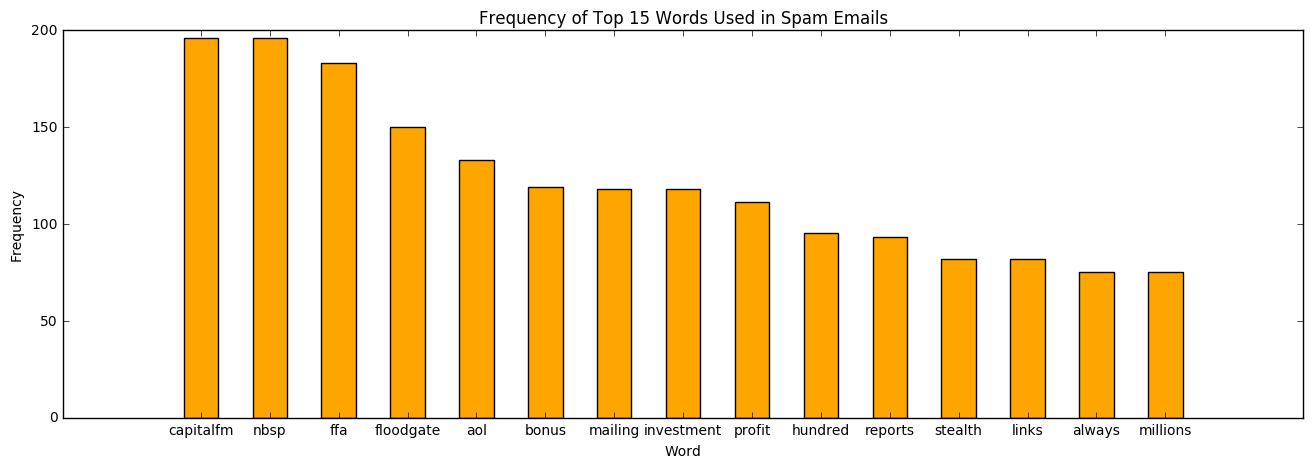

In [367]:
graph_x = list(email_fifteen_largest.index)
graph_y = list(email_fifteen_largest.get_values())
# Add spacing between bars
spacing = np.arange(len(graph_x))
plt.figure(figsize=(16,5))
# Create bar graph
plt.bar(spacing,graph_y,width=0.5,align='center',color = 'orange',alpha=1.0)
plt.xticks(spacing,graph_x)
# Add axes and title
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 15 Words Used in Spam Emails')
plt.show()

Through the transformations on email data, we can determine that there are fewer references to money, fewer spacing mistakes, and fewer acronyms which is why email spam may be tougher to detect than SMS spam. Since there is more variety in the topics within the top fifteen spam words for email, it opens up the opportunity for future research into whether spammers change tactics because recipients are more likely to read long emails rather than long SMS messages. Interestingly, 'capitalfm' seemed to be the most common phrase in all spam, but that may be because of where the email dataset sourced its data. Since there are still references to money, such as 'millions' and 'profit', we can see some similarity between SMS spam and email spam. Next we will do transformations to determine the most common topics and words in both email spam and SMS spam. 

<a id='3'></a>
### Finding the Most Common Words Used Across Spam Email and Spam SMS

Now that we've found the most frequently used words in spam/ham SMS and email, we are going to determine which words are most commonly used in both spam SMS messages and spam emails. This will help us figure out the similarity between spam SMS messages and spam emails.

In [368]:
# Create sets of the data and do set intersection to get common words
email_spam = set([ line for line in only_email_spam_df.index])
SMS_spam = set([ line for line in only_SMS_spam_df.index])
common_words_set = email_spam.intersection(SMS_spam)

In [369]:
common = {}

# Create a dict of the frequencies. 
# For each word, we add the count from 
# only_email_spam and only_SMS_spam
for word in common_words_set:
    common[word] = only_email_spam_df.ix[word]['count'] + only_SMS_spam_df.ix[word]['count']

# Make a dataframe of common words
common_words_df = pd.DataFrame.from_dict(common,orient='index')
# Rename columns
common_words_df.columns = ['count']
# Display dataframe
common_words_df.head()

,count
chart,12
replies,2
unsubscribe,43
growing,4
delivered,6


##### Top 50 frequently used words in both email and SMS spam

In [370]:
# Get the top 50
common_largest = common_words_df['count'].nlargest(50)
# Get the top 15 (for graphing)
common_15_largest = common_words_df['count'].nlargest(15)
# Display top 50
common_largest

bonus          121
guaranteed      66
won             52
marketing       48
unsubscribe     43
amazing         31
largest         30
upgrade         28
stamped         21
rental          21
tips            19
premium         19
fraction        18
newest          18
warranty        17
singles         17
dating          17
fastest         16
porn            16
recieve         15
abuse           14
fantasy         14
tune            14
chart           12
charged         12
bundle          11
passion         11
erotic          10
clip            10
horny            9
sexiest          9
entitled         9
quiz             9
spree            9
optin            8
discreet         7
arsenal          7
customers        7
delivered        6
records          6
revealed         6
improved         6
deals            6
companies        5
flag             5
optout           5
growing          4
soundtrack       4
refused          4
loyalty          4
Name: count, dtype: int64

##### Visualize The Data

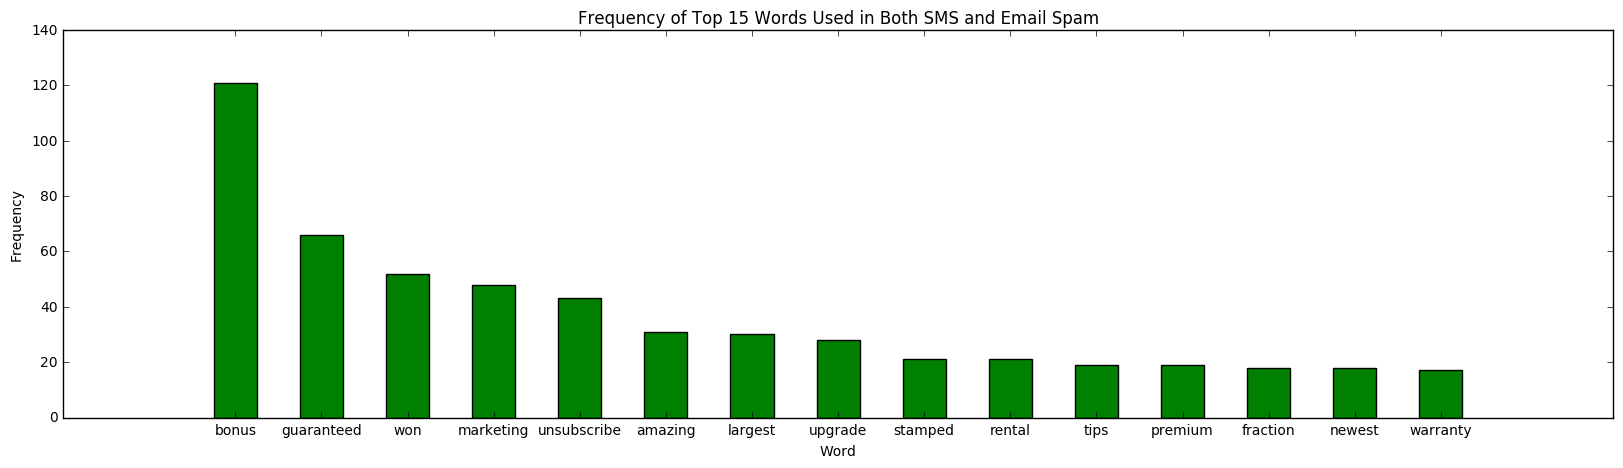

In [371]:
graph_x = list(common_15_largest.index)
graph_y = list(common_15_largest.get_values())
# Add spacing between bars
spacing = np.arange(len(graph_x))
plt.figure(figsize=(20,5))
# Create bar graph
plt.bar(spacing,graph_y,width=0.5,align='center',color = 'green',alpha=1.0)
plt.xticks(spacing,graph_x)
# Add axes and title
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 15 Words Used in Both SMS and Email Spam')
plt.show()

As shown by the above dataframe and graph, words such as 'bonus', 'guaranteed', and 'won' are commonly used in both SMS and email spam messages. Their prevalence in spam messages indicates that scammers rely on ploys that involve telling the recipient that they have won something, regardless of platform the messages are sent through. 

<a id='4'></a>
## Building a Basic Text Classifier Using Machine Learning

Since we have analyzed our data, the next step is to build a classifier that distinguishes between spam and ham SMS and email messages. The code below will do just that. We start off by transforming our SMS and email data in a form that can be used by different classifiers. Then, we will evaluate classifier accuracy for different classifiers. Once we find a classifier that best suits our needs, we will use that classifier to predict whether a given SMS or email message is spam or not.

<a id='5'></a>
### Transform SMS Data

First, we will create a new column in our SMS dataframe that will indicate whether the message in each row is spam (1) or ham (0). We need to transform our classes (spam or ham) to binary values because the classifiers need binary numbers and not strings.

In [372]:
# Add a new column in the SMS dataframe with 0 and 1 indicating
# whether a message is spam or not. Spam == 1, ham == 0
SMS_spamham_data['sorh'] = np.where(SMS_spamham_data['Spam or Ham'] == 'spam', 
                                '1', '0')

Next, we generate two lists of SMS data. The first list, SMS_spam_train_data will contain the SMS messages in our dataframe that will be used to train our classifiers. The second list, SMS_spam_train_target will contain the list of spam or ham classification tags. Note that the number of items in this list will correspond to the number of items in the first list. 

In [373]:
# Create a list of SMS messages and a corresponding list
# of whether that message is spam or ham
SMS_spam_train_data = list(SMS_spamham_data['SMS Message'])
SMS_spam_train_target = list(SMS_spamham_data['Spam or Ham'])

In the code below, we perform the transformations on our data. First, we convert our target labels to binary. Then, we do feature extraction on our data. The 'CountVectorizer' function from Scikit-Learn converts a collection of text documents (SMS messages) to a matrix of token counts. The 'TfidfTransformer' method then transforms the count matrix to a normalized tf or tf-idf representation. 'Tf' stands for term-frequency while 'tf-idf' means term-frequency times inverse document-frequency. In document/text classification, this is the most commonly used term weighting scheme in information retrieval. We use the tf-idf instead of raw frequencies of occurrence of a token in a given document because we need to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [374]:
# Binarize targets 
lb = preprocessing.LabelBinarizer()
SMS_spam_train_target = np.array([number[0] for number in lb.fit_transform(SMS_spam_train_target)])

# Transform data
count_vect = CountVectorizer(decode_error = 'replace')
X_sms_train_counts = count_vect.fit_transform(SMS_spam_train_data)
tfidf_transformer = TfidfTransformer()
X_sms_train_tfidf = tfidf_transformer.fit_transform(X_sms_train_counts)

<a id='6'></a>
### Transform Email Data

We do the same procedure as above on email messages.

In [375]:
# Add a new column in the email dataframe with 0 and 1 indicating
# whether a message is spam or not. Spam == 1, ham == 0
email_spamham_data['sorh'] = np.where(email_spamham_data['Spam or Ham'] == 'spam', 
                                '1', '0')

# Create a list of email messages and a corresponding list
# of whether that message is spam or ham
email_spam_train_data = list(email_spamham_data['Email Message'])
email_spam_train_target = list(email_spamham_data['Spam or Ham'])

# Binarize data
lb = preprocessing.LabelBinarizer()
email_spam_train_target = np.array([number[0] for number in lb.fit_transform(email_spam_train_target)])

# Transform data
count_vect = CountVectorizer(decode_error = 'replace')
X_email_train_counts = count_vect.fit_transform(email_spam_train_data)
tfidf_transformer = TfidfTransformer()
X_email_train_tfidf = tfidf_transformer.fit_transform(X_email_train_counts)

<a id='7'></a>
### Calculating Classifier Metrics

Our next step is to calculate classifier metrics for different classifiers. In the code below, we create a method that takes in a classifier as its parameter and performs evaluation on that classifier. We are going to measure a classifier's accuracy, precision,recall,and f1 statistic. Accuracy refers to how close the measurements are to the known value, so higher accuracy means it was able to predict better. Precision refers to how close to measurements are to one another, so it represents how consistently it predicted values. Recall is the ratio of correctly predicted values / values predicted. The f1 score is the average of precision and recall and is used for identifying which model best fits the data sampled. 

In [376]:
# Method that calculates accuracy, f1 statistic,
# precision, and recall for a provided classifier. 
def calculate_metrics(classifier,name_of_classifier,training_tfidf,target):
    
    classifier_score_list = []
    classifier_score_list.append(name_of_classifier)

    # Calculate accuracy score (Round to 4 decimal places)
    scores0 = cross_validation.cross_val_score(classifier, training_tfidf, target, cv= 10, scoring = 'accuracy')
    data0 = "Accuracy: %0.4f" % (scores0.mean())
    classifier_score_list.append(data0)
        
    # Calculate f1 score
    scores1 = cross_validation.cross_val_score(classifier, training_tfidf, target, cv=10, scoring = 'f1')
    data1 = "f1: %0.4f " % (scores1.mean())
    classifier_score_list.append(data1)

    # Calculate precision score
    scores2 = cross_validation.cross_val_score(classifier, training_tfidf, target, cv=10,scoring = 'precision')
    data2 = "Precision: %0.4f" % (scores2.mean())
    classifier_score_list.append(data2)

    # Calculate recall score
    scores3 = cross_validation.cross_val_score(classifier, training_tfidf, target, cv=10, scoring = 'recall')
    data3 = "Recall: %0.4f" % (scores3.mean())
    classifier_score_list.append(data3)
    
    # Returns all the scores for a specific classifier
    return classifier_score_list

<a id='8'></a>
### Evaluating Classifiers

Using Scikit-Learn, we will fit various classifiers on our data to determine which classifier would be better for training a spam filter. The list of classifiers used in the function below is not exhaustive. Please feel free to test a variety of other classifiers to see their performance on our SMS and email data.

In [377]:
# Method that will evaluate different classifiers
def evaluate_classifier(classifier,training_tfidf,target):
        
    if classifier == "SVM":
        svm_clf = svm.SVC(kernel='linear', C=1).fit(training_tfidf,target)
        # Calculate metrics
        classifier_metrics = calculate_metrics(svm_clf,classifier,training_tfidf,target)

    elif classifier == "MultinomialNB":
        mnb_clf = MultinomialNB().fit(training_tfidf,target)
        classifier_metrics = calculate_metrics(mnb_clf,classifier,training_tfidf,target)

    elif classifier == "LinearSVC":
        lsvc_clf = svm.LinearSVC().fit(training_tfidf,target)
        classifier_metrics = calculate_metrics(lsvc_clf,classifier,training_tfidf,target)

    elif classifier == "SGD":
        sgd_clf = linear_model.SGDClassifier().fit(training_tfidf,target)
        classifier_metrics = calculate_metrics(sgd_clf,classifier,training_tfidf,target)

    elif classifier == "NearestCentroid":
        nc_clf = NearestCentroid().fit(training_tfidf,target)
        classifier_metrics = calculate_metrics(nc_clf,classifier,training_tfidf,target)

    elif classifier == "DecisionTree":
        dt_clf = tree.DecisionTreeClassifier(random_state = 0).fit(training_tfidf,target)
        classifier_metrics = calculate_metrics(dt_clf,classifier,training_tfidf,target)

    elif classifier == "AdaBoost":
        ab_clf = ensemble.AdaBoostClassifier().fit(training_tfidf,target)
        classifier_metrics = calculate_metrics(ab_clf,classifier,training_tfidf,target)

    elif classifier == "RandomForest":
        rf_clf = ensemble.RandomForestClassifier().fit(training_tfidf,target)
        classifier_metrics = calculate_metrics(rf_clf,classifier,training_tfidf,target)

    elif classifier == "KNeighbors":
        kn_clf = KNeighborsClassifier(n_neighbors = 3).fit(training_tfidf,target)
        classifier_metrics = calculate_metrics(kn_clf,classifier,training_tfidf,target)

    return classifier_metrics

#### SMS Data

First, we evaluate all the classifiers listed above with SMS Data to see their performance.

In [378]:
# Run the classifiers, get their statistics, and print them for SMS data
SVM = evaluate_classifier("SVM", X_sms_train_tfidf, SMS_spam_train_target)
LinearSVC = evaluate_classifier("LinearSVC", X_sms_train_tfidf, SMS_spam_train_target)
SGD = evaluate_classifier("SGD", X_sms_train_tfidf, SMS_spam_train_target)
DecisionTree = evaluate_classifier("DecisionTree", X_sms_train_tfidf, SMS_spam_train_target)
AdaBoost = evaluate_classifier("AdaBoost", X_sms_train_tfidf, SMS_spam_train_target)
RandomForest = evaluate_classifier("RandomForest", X_sms_train_tfidf, SMS_spam_train_target)
KNeighbors = evaluate_classifier("KNeighbors", X_sms_train_tfidf, SMS_spam_train_target)

print(SVM)
print(LinearSVC)
print(SGD)
print(DecisionTree)
print(AdaBoost)
print(RandomForest)
print(KNeighbors)

['SVM', 'Accuracy: 0.9842', 'f1: 0.9380 ', 'Precision: 0.9868', 'Recall: 0.8943']
['LinearSVC', 'Accuracy: 0.9833', 'f1: 0.9341 ', 'Precision: 0.9869', 'Recall: 0.8875']
['SGD', 'Accuracy: 0.9849', 'f1: 0.9417 ', 'Precision: 0.9869', 'Recall: 0.8996']
['DecisionTree', 'Accuracy: 0.9715', 'f1: 0.8913 ', 'Precision: 0.9082', 'Recall: 0.8767']
['AdaBoost', 'Accuracy: 0.9745', 'f1: 0.9004 ', 'Precision: 0.9432', 'Recall: 0.8634']
['RandomForest', 'Accuracy: 0.9738', 'f1: 0.8970 ', 'Precision: 0.9936', 'Recall: 0.8045']
['KNeighbors', 'Accuracy: 0.9244', 'f1: 0.6062 ', 'Precision: 1.0000', 'Recall: 0.4365']


# I need to add info about which classifier is best

#### Email Data

Next, we evaluate classifiers with email data

In [379]:
# Run the classifiers, get their statistics, and print them for Email data
SVM = evaluate_classifier("SVM", X_email_train_tfidf, email_spam_train_target)
LinearSVC = evaluate_classifier("LinearSVC", X_email_train_tfidf, email_spam_train_target)
SGD = evaluate_classifier("SGD", X_email_train_tfidf, email_spam_train_target)
DecisionTree = evaluate_classifier("DecisionTree", X_email_train_tfidf, email_spam_train_target)
AdaBoost = evaluate_classifier("AdaBoost", X_email_train_tfidf, email_spam_train_target)
RandomForest = evaluate_classifier("RandomForest", X_email_train_tfidf, email_spam_train_target)
KNeighbors = evaluate_classifier("KNeighbors", X_email_train_tfidf, email_spam_train_target)

print(SVM)
print(LinearSVC)
print(SGD)
print(DecisionTree)
print(AdaBoost)
print(RandomForest)
print(KNeighbors)

['SVM', 'Accuracy: 0.9927', 'f1: 0.9926 ', 'Precision: 0.9959', 'Recall: 0.9896']
['LinearSVC', 'Accuracy: 0.9927', 'f1: 0.9926 ', 'Precision: 0.9959', 'Recall: 0.9896']
['SGD', 'Accuracy: 0.9917', 'f1: 0.9916 ', 'Precision: 0.9959', 'Recall: 0.9875']
['DecisionTree', 'Accuracy: 0.9469', 'f1: 0.9479 ', 'Precision: 0.9324', 'Recall: 0.9646']
['AdaBoost', 'Accuracy: 0.9792', 'f1: 0.9791 ', 'Precision: 0.9813', 'Recall: 0.9771']
['RandomForest', 'Accuracy: 0.9740', 'f1: 0.9720 ', 'Precision: 0.9659', 'Recall: 0.9646']
['KNeighbors', 'Accuracy: 0.9708', 'f1: 0.9717 ', 'Precision: 0.9578', 'Recall: 0.9875']


### Analysis of Classifiers

Interestingly, when the code above is run, the statistics change per run, but through our testing, we've seen that SVM, LinearSVC, and SGD, performed best on SMS data followed by DecisionTree and RandomForest. For emails, SVM, LinearSVC, and SGD come out on top while AdaBoost and RandomForest closely following behind. The ranking of classifiers is based on accuracies. 

<a id='9'></a>
### Example Application of Chosen Best Classifer on SMS and Email Messages

In [386]:
def label(message,training_tfidf,target_set):
        
    svm_clf = svm.SVC(kernel='linear', C=1).fit(training_tfidf,target_set)
        
    docs_new = []
    docs_new.append(message)
        
    X_new_counts = count_vect.transform(docs_new)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = svm_clf.predict(X_new_tfidf)
        
    return predicted

# ADD more messages: 10 for SMS, 10 for Email. Lets make it correctly identify a few spam and ham and incorrectly identify a few others so we can talk about that discrepancy

In [387]:
label("claim your prize. You've won millions!!",X_sms_train_tfidf,SMS_spam_train_target)[0]

ValueError: X.shape[1] = 22744 should be equal to 8672, the number of features at training time

In [ ]:
label("Hi mom, how are you?")[0]

## Insight

Based on the results above, we can see that the models effectively predicted whether a message is spam or ham if it used enough of the top words we found in spam SMS and spam email. SVM, LinearSVC, and SGD all performed equally in our tests, therefore we believe it would be effective to use them to create a spam filter. Decision Trees or Random Forests could also work, if given a diverse training set.

## Summary and References

This tutorial showed you how to create a very basic spam text classifier using Scikit-Learn. If you are interested in learning more about text classification, Scikit-Learn or machine learning in general, please feel free to visit the following websites.

1. Kaggle: [https://www.kaggle.com/](https://www.kaggle.com/)
2. Scikit-Learn: [http://scikit-learn.org/stable/](http://scikit-learn.org/stable/)
3. Andrew Ng's Machine Learning course at Stanford: [https://www.coursera.org/learn/machine-learning](https://www.coursera.org/learn/machine-learning)
4. UCI Machine Learning Repository: [https://archive.ics.uci.edu/ml/datasets/sms+spam+collection](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)